# Velocity and pumping diagnostics after PharaGlow analysis (for videos without lawns)

## Changing names (user input required)

#### Strain directories

In [1]:
# ADD DIRECTORY OF STRAIN MASTER FOLDER(S)
nl_nosmell = '/media/soma/Nicolina/GRU101/No_lawn/No_smell/'
nl_5min = '/media/soma/Nicolina/GRU101/No_lawn/Smell_5min/'
nl_30min = '/media/soma/Nicolina/GRU101/No_lawn/Smell_30min/'

# FINAL FIGURE NAME AND DIRECTORY (figure name MUST have .pdf at the end) - if not changed then the previous figure
# WILL be erased so be careful!
hist_name = "/home/nzjacic/Desktop/Diagnostics/Figures/Analysis_2/Nolawn_{}_diagnostics_average.pdf"

#### Dictionary linking strain names to their folders and graph colors

In [28]:
# ADD STRAIN NAMES
strains = ['no_smell', '5min_smell', '30min_smell']

# ADD DIRECTORY VARIABLE
directories = [nl_nosmell, nl_5min, nl_30min]

# ADD COLORS
# if a syntax error comes up it's probably because you forgot to add a comma after the previous strain name
colors = {
        'no_smell': 'xkcd:lavender',
        '5min_smell': 'xkcd:salmon',
        '30min_smell': 'xkcd:teal'
    }

#### Variables

In [4]:
# FPS?
fps = 30

# HOW MANY MICRONS PER PIXEL?
umPerPx = 2.34

## Extracting velocity and pumping information

### Importing packages

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pickle
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import extract, util
from pharaglow.util import smooth

### Defining functions and dictionaries

#### Defining functions to extract velocity, pumping and kymo

In [6]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(pumps, ws = 30, prs = np.linspace(0.5,0.95,50) ):
    return extract.bestMatchPeaks(pumps, ws, prs)

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

#### Defining how Python reads in Pharaglow and lawn data

In [7]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(pumps, wsDetrend = 300 , wsOutlier = 300, wsDetrendLocal = 30, prs = np.linspace(0.5,0.95,50) ):
    return extract.bestMatchPeaks(pumps, wsDetrend = 300 , wsOutlier = 300, wsDetrendLocal = 30, prs = prs)

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

def readData(dataFolder, umPerPx, fps, j = 0, nmax = None):
    df = {}
    path = os.path.dirname(dataFolder)
    for fn in os.listdir(path):
        if nmax != None and len(df.keys())>nmax-1:
            break
        file = os.path.join(path,fn)
        if os.path.isfile(file) and 'results_' in fn and fn.endswith('.json'):
            print('Reading', file)
            particle_index = int(fn.split('.')[0].split('_')[-1])
            traj =  pd.read_json(file, orient='split', numpy = True)
            # velocity
            t = traj['frame']/fps
            v = getVelocity(traj, umPerPx, fps)
            # pumping related data
            kymo = getKymo(traj, 'Straightened')
            rawPump = [-np.max(np.std(sIm, axis =1), axis =0) for sIm in traj['Straightened']]
            traj['pump'] = rawPump
            prs =  np.linspace(0.15,1.00,50)
            p, pump, pks, roc, metric  = getPumps(traj['pump'].values, prs = prs)
            #plotPumpAnalysis(pump, pks, roc, prs, time = traj['frame'], metric=metric)
            pinterp = np.interp(traj['frame'], p[:-1]+traj['frame'].iloc[0], fps/np.diff(p))
            # get a binary trace where pumps are 1 and non-pumps are 0
            tmp = np.zeros(len(t))
            tmp[p] = 1
            
            df[j] = {'time': t.values,
                     'x': traj['x'].values,
                     'y': traj['y'].values,
                             'velocity':v,
                             'peaks': p.values,
                             'pumpTrace':pump,
                             'binaryPumps': tmp,
                             'pumpInterp': pinterp,
                             'pid':particle_index,
                             'filename': fn,
                             'kymo': kymo,
                             'fps': fps,
                             'scale':umPerPx
                            }
            j +=1
    return df

#### Defining histogram plotting function

In [51]:
def graphingNolawn(Data, condition, plotpath, save = 'Yes'):
    # setting up Grid plot
    f1 = plt.figure(figsize = (16,8))
    grid = mpl.gridspec.GridSpec(ncols=2, nrows =1)
    ax1 = f1.add_subplot(grid[:,0]) 
    ax2 = f1.add_subplot(grid[:,1])
    # extracting histogram information
    pr, v = [], []
    for idx in Data.keys():
        print(Data[idx]['filename'])
        tmp = Data[idx]['pumpInterp']
        pr.append(tmp)
        v.append(Data[idx]['velocity'])
    pr = np.concatenate(pr, axis = None)
#     print(len(pr))
    v = np.concatenate(v, axis = None)
#     print(len(v))
    binspr = np.linspace(0,6,15)
    binsv = np.linspace(0, 400, 50)
    # pumping rate
    #histpr = np.histogram(pr, bins, color = colors[condition], density=True)
    ax1.hist(pr, binspr, color = colors[condition], density = True)
    #ax1.hist(histpr, bins)
    # velocity
    #histv = np.histogram(v, bins, color = colors[condition], density=True)
    ax2.hist(v, binsv, color = colors[condition], density = True)
    #ax2.hist(histv, bins)
    print ('Plotting', condition+'...')
    ax1.set_xlabel('Pumping rate (Hz)')
    ax1.set_ylabel('PDF')
    ax2.set_ylabel('PDF')
    ax2.set_xlabel('Velocity (um/s)')
    # saving data variable
    plotpath = plotpath.format(condition)
    print('Ta da!')
    # OPTIONAL - save figure
    if save == 'Yes':
        print(plotpath)
        plt.savefig(plotpath)
    else:
        print('Not saved')

#### Defining saving and loading process

In [33]:
def readPharaglow(strains, directories, index, save=True):
    Data = readData(directories[index], umPerPx, fps, nmax = None)
    if save:
        saveData = open(f'/home/nzjacic/Desktop/Diagnostics/Saved_data/Analysis_2/{strains[index]}', 'wb')
        pickle.dump(Data, saveData)
        saveData.close()

In [34]:
def loadPharaglow(strains, directories, index):
    saveData = open(f'/home/nzjacic/Desktop/Diagnostics/Saved_data/Analysis_2/{strains[index]}', 'rb')
    Data = pickle.load(saveData)
    saveData.close()
    return Data

### Reading and Graphing (add as strains increase)

#### No smell patch

In [35]:
# readPharaglow(strains, directories, index=0)

NZ0197_results_6.json
NZ0189_results_2.json
NZ0197_results_11.json
NZ0189_results_40.json
NZ0189_results_39.json
NZ0197_results_3.json
NZ0197_results_4.json
NZ0189_results_23.json
NZ0189_results_22.json
NZ0197_results_5.json
NZ0197_results_10.json
NZ0189_results_44.json
NZ0189_results_618.json
NZ0189_results_56.json
NZ0189_results_24.json
NZ0197_results_2.json
NZ0189_results_0.json
NZ0189_results_50.json
NZ0189_results_35.json
NZ0197_results_0.json
NZ0189_results_1.json
NZ0189_results_21.json
NZ0189_results_12.json
NZ0189_results_7.json
Plotting no_smell...
Ta da!
/home/nzjacic/Desktop/Diagnostics/Figures/Analysis_2/Nolawn_no_smell_diagnostics_average.pdf


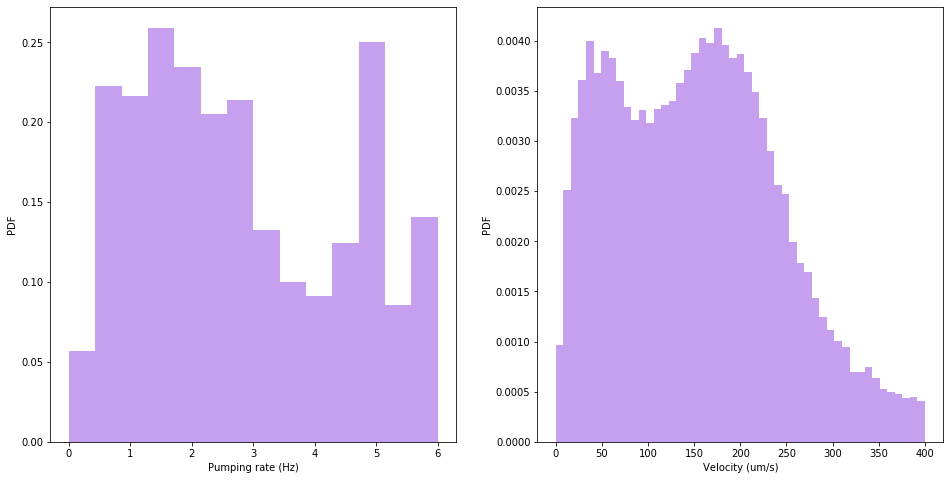

In [52]:
Data = loadPharaglow(strains, directories, index=0)
# change plot variable and method
graphingNolawn(Data, strains[0], hist_name, save = 'Yes')

#### Smell patch left to dry for 5 minutes

In [53]:
# readPharaglow(strains, directories, index=1)

NZ0198_results_42.json
NZ0198_results_19.json
NZ0198_results_38.json
NZ0198_results_21.json
NZ0198_results_12.json
NZ0198_results_4.json
NZ0198_results_29.json
NZ0198_results_15.json
NZ0198_results_5.json
NZ0198_results_16.json
NZ0198_results_0.json
NZ0198_results_8.json
NZ0198_results_40.json
NZ0198_results_1.json
NZ0198_results_37.json
NZ0198_results_35.json
NZ0198_results_41.json
NZ0198_results_3.json
NZ0198_results_32.json
NZ0198_results_10.json
NZ0198_results_39.json
Plotting 5min_smell...
Ta da!
/home/nzjacic/Desktop/Diagnostics/Figures/Analysis_2/Nolawn_5min_smell_diagnostics_average.pdf


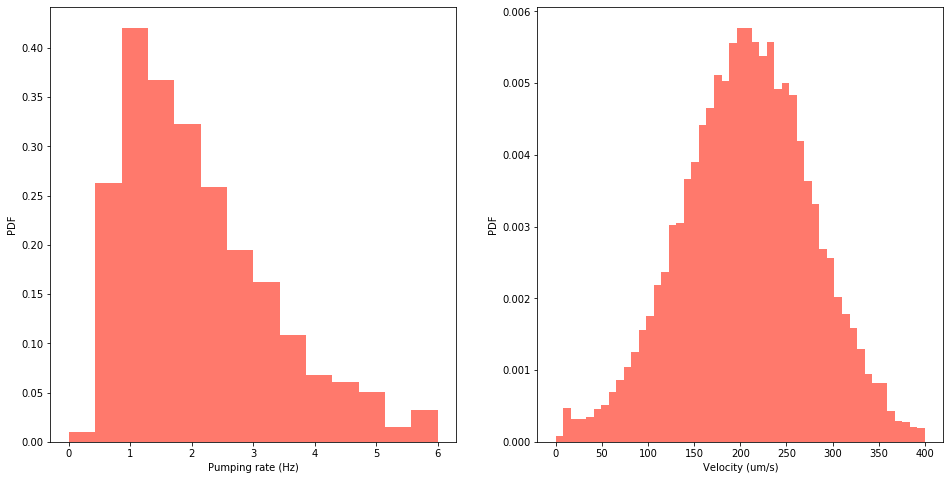

In [54]:
Data = loadPharaglow(strains, directories, index=1)
# change plot variable and method
graphingNolawn(Data, strains[1], hist_name, save = 'Yes')

#### Smell patch left to dry for 30 minutes

In [55]:
# readPharaglow(strains, directories, index=2)

NZ0196_results_47.json
NZ0196_results_4.json
NZ0196_results_41.json
NZ0196_results_27.json
NZ0196_results_22.json
NZ0196_results_50.json
NZ0196_results_45.json
NZ0196_results_20.json
NZ0196_results_24.json
NZ0196_results_42.json
NZ0196_results_26.json
NZ0196_results_44.json
NZ0196_results_48.json
NZ0196_results_10.json
NZ0196_results_23.json
NZ0196_results_5.json
NZ0196_results_39.json
NZ0196_results_46.json
NZ0196_results_8.json
NZ0196_results_30.json
Plotting 30min_smell...
Ta da!
/home/nzjacic/Desktop/Diagnostics/Figures/Analysis_2/Nolawn_30min_smell_diagnostics_average.pdf


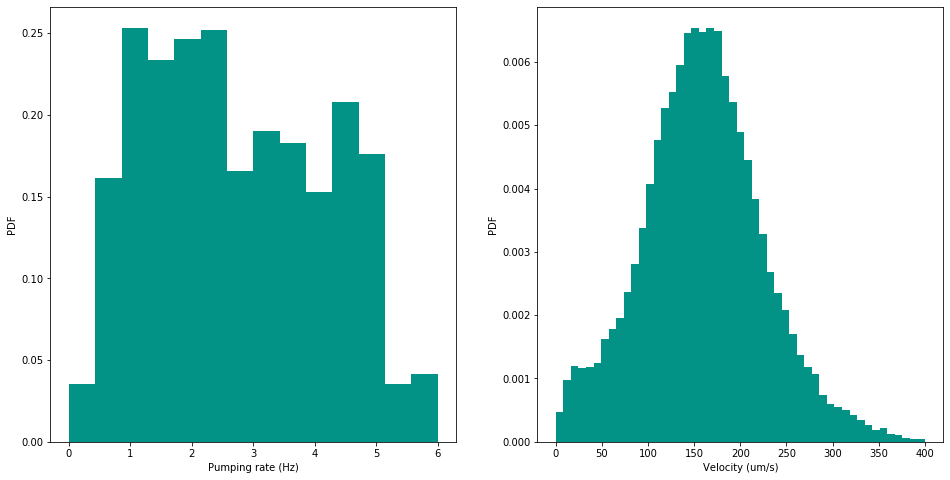

In [56]:
Data = loadPharaglow(strains, directories, index=2)
# change plot variable and method
graphingNolawn(Data, strains[2], hist_name, save = 'Yes')